# Effective Convergence
*24 January 2020*

In this notebook, we'll be using an idea I didn't realize up till now, that we can define the effective convergence as:
$$\kappa_\mathrm{eff} = \frac{1}{2} \nabla \cdot \vec\alpha$$
(thanks to [Gilman+ 2019](https://arxiv.org/pdf/1901.11031.pdf)).

Note that we're updating from `lenstronomy 1.0.1` to `1.3.0` (this new version has tNFW profiles).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u

from scipy import fftpack
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad
from scipy.stats import poisson

from collections import Counter

from helpers import CustomImage, autoshow, ADD, sigma_cr

In [25]:
# Basic parameters
zl = 0.5
zs = 1.
# pixnum, pixsize = 200, .008 # to match S. Birrer's paper (roughly)
# ext = pixnum * pixsize / 2.
pixnum = 200
ext = 8. # should be .8 to match Simon's paper
pixsize = 2*ext / pixnum
print(pixsize)

0.08


In [26]:
## Calculate physical size of image
# ( note: 845000 kpc to z=.2 )
# distance = 1947000 # kpc to z=.5

cosmo = FlatLambdaCDM(H0=70, Om0=0.316)

com_l = cosmo.comoving_distance(zl).to(u.kpc).value
com_s = cosmo.comoving_distance(zs).to(u.kpc).value
angle = (2*ext) * np.pi/648000 # rad
com_width_kpc = com_l * angle # comoving width in kpc
print(com_width_kpc, 'kpc')

145.69745638522323 kpc


In [27]:
# vol_rough = com_width_kpc**2 * com_s # kpc^3
# # 3.391e6
# print('comoving volume is approx', vol_rough / 1e6, 'million kpc^3')
# del vol_rough

## Double cone shape

In [28]:
def double_cone_direct(com_z, com_l, com_s):
    # Input can be in any units
    if com_z < com_l:
        return com_z / com_l
    else:
        return (com_s - com_z) / (com_s - com_l)

def double_cone(z, zl=zl, zs=zs):
    com_z = cosmo.comoving_distance(z)
    com_l = cosmo.comoving_distance(zl)
    com_s = cosmo.comoving_distance(zs)
    return double_cone_direct(com_z, com_l, com_s)

#zlist = np.linspace(0, zs, 100)
#doubleconelist = [double_cone(z) for z in zlist]
#comlist = [cosmo.comoving_distance(z).to(u.Mpc).value for z in zlist]

# plt.plot(zlist, [double_cone(z) for z in zlist]); plt.show()
# plt.plot(comlist, doubleconelist); plt.show()

com_l = cosmo.comoving_distance(zl).to(u.kpc).value
com_s = cosmo.comoving_distance(zs).to(u.kpc).value
print('com_l', com_l, 'com_s', com_s)
print('integral (in kpc)', quad(lambda comz: double_cone_direct(comz, com_l, com_s)**2, 0, com_s))

double_cone_volume_kpc = com_width_kpc**2 * quad(lambda comz: double_cone_direct(comz, com_l, com_s)**2, 0, com_s)[0]
# volume of double-cone in kpc**3 (really double prism)

print('double prism volume', double_cone_volume_kpc / 1e6, 'million kpc^3')

com_l 1878266.1007495527 com_s 3273038.879969728
integral (in kpc) (1091012.9599993005, 0.011328151325592964)
double prism volume 23159.749049271875 million kpc^3


## Substructure
### Interlopers

Units: `massesn` has units of $M_\odot$. `massfunc` has units of 1/(Mpc/h)^3 / M_sun (comoving distance).

In [29]:
# Load Sheth-Tormen results
h = .675
massesn = np.load('files/st_results/WIDE_massesn_ST.npy') # units solar masses
massfunc_matrix = np.load('files/st_results/WIDE_massfunc_ST.npy') * h**3/1000**3 # convert Mpc/h^3 to 1/kpc^3
zlist = np.load('files/st_results/WIDE_redshifts_ST.npy') # redshifts

massfunc = interp2d(zlist, massesn, massfunc_matrix, bounds_error=False) # function of (z, mass)

In [30]:
def ps_integrand(mass):
    # rough so ignore redshift dependence
    return massfunc(zl, mass)

normalization = quad(lambda z: double_cone(z, zl, zs), 0, zs)[0]
def ps_integrand_fancy(mass):
    return (quad(lambda z: double_cone(z, zl, zs) * massfunc(z, mass), 0, zs)[0] 
            / normalization)

In [31]:
#mass_bins_interlopers = [1e5, 1e6, 1e7, 1e8]
mass_bins_interlopers = np.logspace(5,8,20)[:-1]
bin_ratio = mass_bins_interlopers[1]/mass_bins_interlopers[0]
print('mass_bins_interlopers:',mass_bins_interlopers)
avg_nums_interlopers = np.array([double_cone_volume_kpc * quad(ps_integrand_fancy, mass, bin_ratio*mass)[0] for mass in mass_bins_interlopers])

mass_bins_interlopers: [  100000.           143844.98882877   206913.80811148   297635.14416313
   428133.23987194   615848.21106603   885866.79041008  1274274.98570313
  1832980.71083244  2636650.89873036  3792690.19073225  5455594.78116851
  7847599.70351461 11288378.91684688 16237767.39188721 23357214.69090121
 33598182.86283781 48329302.38571752 69519279.61775605]


number 60540.39400693692 : [17382.8659582  12389.86259207  8832.73834134  6299.54540968
  4494.92447441  3208.32950763  2290.84369034  1636.14066984
  1169.2234049    835.70151011   597.62374561   427.59536214
   306.07458693   219.18896056   157.02110931   112.55627918
    80.70089382    57.89842195    41.55908892]


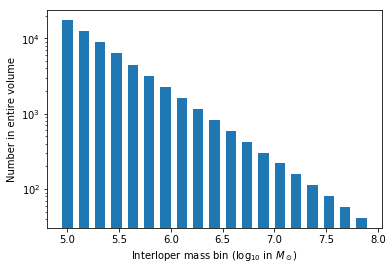

In [32]:
plt.bar(np.log10(mass_bins_interlopers), avg_nums_interlopers, log=True, width=.1)
plt.xlabel(r'Interloper mass bin ($\log_{10}$ in $M_\odot$)')
plt.ylabel('Number in entire volume')
print('number', np.sum(avg_nums_interlopers), ':', avg_nums_interlopers)

### Subhalos

Just a very rough estimate of the mass function:

In [33]:
phys_width_kpc = 2 * ext * np.pi/648000  * ADD(0, zl).to(u.kpc).value
print('phys width (kpc):', phys_width_kpc)

phys width (kpc): 97.13163759014881


In [34]:
# einst_radius = 1 * np.pi/648000 * ADD(0,zl).to(u.kpc)
# print(einst_radius)

mass bins sub: ['100000', '143845', '206914', '297635', '428133', '615848', '885867', '1.27427e+06', '1.83298e+06', '2.63665e+06', '3.79269e+06', '5.45559e+06', '7.8476e+06', '1.12884e+07', '1.62378e+07', '2.33572e+07', '3.35982e+07', '4.83293e+07', '6.95193e+07']
number 62920.58635240366 [17594.18188345 12684.22140533  9144.47024164  6592.5478063
  4752.78342319  3426.43708191  2470.23060613  1780.87007046
  1283.88750426   925.5965109    667.29281043   481.07322101
   346.82142585   250.03491397   180.25835068   129.9541431
    93.68819389    67.54288447    48.69387543]


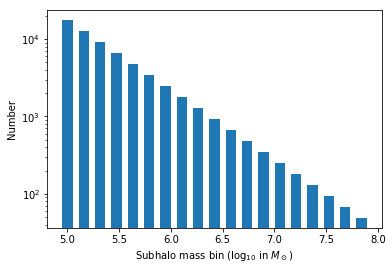

In [35]:
Sigma_sub = 0.012 # kpc^-2
m0 = 1e8 # Msun
dNdm_sub = lambda m: Sigma_sub / m0 * (m / m0)**-1.9 * phys_width_kpc**2 # 1/Msun
#dNdm_sub = lambda m: Sigma_sub / m0 * (m / m0)**-1.9 * (np.pi*6.3)**2 #phys_width_kpc**2 # 1/Msun
# I think we should use the physical width, but not 100% sure

mass_bins_sub = np.logspace(5,8,20)[:-1]
bin_ratio = mass_bins_sub[1]/mass_bins_sub[0]
print('mass bins sub:', ['%g'%x for x in mass_bins_sub])
avg_nums_sub = np.array([quad(dNdm_sub, mass, bin_ratio * mass)[0] for mass in mass_bins_sub])
plt.bar(np.log10(mass_bins_sub), avg_nums_sub, log=True, width=.1)
#plt.axhline(1)
plt.xlabel(r'Subhalo mass bin ($\log_{10}$ in $M_\odot$)')
plt.ylabel('Number')
print('number', np.sum(avg_nums_sub), avg_nums_sub)

In [36]:
m0 = 1e8 # Msun
dNdm_sub2 = lambda m: 0.125 / m0 * (m / m0)**-1.9 * phys_width_kpc**2 # 1/Msun
#dNdm_sub = lambda m: Sigma_sub / m0 * (m / m0)**-1.9 * (np.pi*6.3)**2 #phys_width_kpc**2 # 1/Msun
# I think we should use the physical width, but not 100% sure

# mass_bins_sub = np.logspace(5.7,10,20)[:-1]
# bin_ratio = mass_bins_sub[1]/mass_bins_sub[0]
print('mass bins sub:', ['%g'%x for x in mass_bins_sub])
avg_nums_sub2 = np.array([quad(dNdm_sub2, mass, bin_ratio * mass)[0] for mass in mass_bins_sub])

mass bins sub: ['100000', '143845', '206914', '297635', '428133', '615848', '885867', '1.27427e+06', '1.83298e+06', '2.63665e+06', '3.79269e+06', '5.45559e+06', '7.8476e+06', '1.12884e+07', '1.62378e+07', '2.33572e+07', '3.35982e+07', '4.83293e+07', '6.95193e+07']


Text(0.5, 1.0, 'Cumulative mass functions')

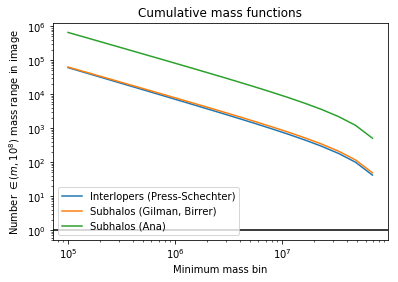

In [37]:
# Graph summing from top
plt.loglog(mass_bins_interlopers,
        [np.sum(avg_nums_interlopers[i:]) for i in range(len(avg_nums_interlopers))],
        label='Interlopers (Press-Schechter)')
plt.loglog(mass_bins_sub,
        [np.sum(avg_nums_sub[i:]) for i in range(len(avg_nums_sub))],
        label='Subhalos (Gilman, Birrer)')
plt.loglog(mass_bins_sub,
        [np.sum(avg_nums_sub2[i:]) for i in range(len(avg_nums_sub2))],
        label='Subhalos (Ana)')
plt.axhline(1, color='k')
plt.xlabel('Minimum mass bin')
plt.ylabel('Number $\\in(m, 10^{8})$ mass range in image')
plt.legend()
plt.title('Cumulative mass functions')
#plt.savefig('imgs/feb18_massfunc_5to8.png')

These next few cells are about relating $\Sigma_\mathrm{sub}$ (the variable Gilman and Birrer's paper used to specify the subhalo mass function normalization) and $\bar\kappa_\mathrm{sub}$ (the variable that Ana used).

 First we calculate $\bar\kappa_\mathrm{sub}$ assuming $\Sigma_\mathrm{sub} = 0.012\,\mathrm{kpc^{-2}}$.

In [38]:
mlow, mhigh = 1e5, 1e8

N_sub = quad(dNdm_sub, mlow, mhigh)[0]
m_avg = quad(lambda m : m * dNdm_sub(m), mlow, mhigh)[0] / N_sub * u.Msun
print('m_avg', m_avg)

kappa_hat_sub = N_sub * m_avg / ((phys_width_kpc*u.kpc)**2) / sigma_cr(zl, zs).to(u.Msun*u.kpc**-2)
kappa_hat_sub

m_avg 897526.8850423881 solMass


<Quantity 0.00192063>

It is a factor of 10 lower! Next, we calculate $\Sigma_\mathrm{sub}$ assuming $\bar\kappa_\mathrm{sub} = .02$.

In [39]:
mlow, mhigh = 1e5, 1e8

N_sub = quad(dNdm_sub, mlow, mhigh)[0]
m_avg = quad(lambda m : m * dNdm_sub(m), mlow, mhigh)[0] / N_sub * u.Msun
print('m_avg', m_avg)

kappa_hat_sub = .02
Sigma_sub2 = kappa_hat_sub * sigma_cr(zl, zs).to(u.Msun/u.kpc**2) / m_avg / quad(lambda m: 1/m0*(m/m0)**-1.9, mlow, mhigh)[0]
print('Sigma_sub', Sigma_sub2)

m_avg 897526.8850423881 solMass
Sigma_sub 0.1249587075951069 1 / kpc2


In [40]:
mlow, mhigh = 10**5.7, 1e10

N_sub = quad(dNdm_sub, mlow, mhigh)[0]
m_avg = quad(lambda m : m * dNdm_sub(m), mlow, mhigh)[0] / N_sub * u.Msun
print('m_avg', m_avg)

kappa_hat_sub = N_sub * m_avg / ((phys_width_kpc*u.kpc)**2) / sigma_cr(zl, zs).to(u.Msun*u.kpc**-2)
kappa_hat_sub

m_avg 7631010.235635903 solMass


<Quantity 0.0038352>

### Sampling (helper functions)

In [41]:
def double_cone_angle(z, zl=zl, zs=zs):
    # angle of how wide the interloeprs can be dispersed so that they'd show up in the final image (according to the double-prism projection)
    
    # returns a ratio, 1 for z <= zl
    
    com_z = cosmo.comoving_distance(z)
    com_l = cosmo.comoving_distance(zl)
    return double_cone(z, zl=zl, zs=zs) * com_l / com_z

#plt.plot(zlist, [double_cone_angle(z) for z in zlist])

In [42]:
# # These are the (somewhat arbitrary) lens system settings used to create the sample image:
# zl = 0.2
# xs = [0,.2]
# ys = [0.5,-.2]
# redshifts = [.2,.25]

In [43]:
# # Now we'll try something more intense
# np.random.seed(123)


# xs, ys, redshifts, masses = [], [], [], []
# for i in range(50):
#     xs.append( np.random.uniform(-.3*ext,.3*ext) )
#     ys.append( np.random.uniform(-.3*ext,.3*ext) )
#     redshifts.append( np.random.uniform(0,1) ) 
#     masses.append( 1e8 )

---
### But first some tests: subhalos only

In [44]:
# Populate the subhalos

np.random.seed(145)
# n_planes = 10

xs, ys, redshifts, masses = [], [], [], []
#xyext = ext

# z_planes = np.linspace(.05,.95,n_planes)
# area_proportions = [double_cone(z)**2 for z in z_planes]
# area_sum = np.sum(area_proportions)

# for i, z_plane in enumerate(z_planes):
#     rv_nums = poisson.rvs(avg_nums_interlopers * area_proportions[i] / area_sum)
#     xyext = ext * double_cone_angle(z_plane)
#     # ^- I thought about multiplying this by 1.5 so we don't get weird boundary effects
#     #print(rv_nums)
#     for mass, num in zip(mass_bins_interlopers, rv_nums):
#         for i in range(num):
#             xs.append(np.random.uniform(-xyext,xyext))
#             ys.append(np.random.uniform(-xyext,xyext))
#             redshifts.append(z_plane)
#             masses.append(mass)
# print('number of interlopers', len(xs))
rv_nums = poisson.rvs(avg_nums_sub) if len(avg_nums_sub) > 1 else [poisson.rvs(avg_nums_sub)]
xyext = ext
for mass, num in zip(mass_bins_sub, rv_nums):
    for i in range(num):
        xs.append(np.random.uniform(-xyext,xyext))
        ys.append(np.random.uniform(-xyext,xyext))
        redshifts.append(zl)
        masses.append(mass)
print('number of subhalos', len(xs))

number of subhalos 62890


In [45]:
Counter(masses)

Counter({100000.0: 17508,
         143844.9888287663: 12694,
         206913.808111479: 9187,
         297635.14416313195: 6615,
         428133.2398719396: 4793,
         615848.2110660267: 3556,
         885866.7904100833: 2417,
         1274274.985703132: 1701,
         1832980.7108324375: 1300,
         2636650.8987303553: 921,
         3792690.1907322537: 663,
         5455594.781168515: 442,
         7847599.703514607: 339,
         11288378.916846883: 235,
         16237767.391887208: 158,
         23357214.690901212: 149,
         33598182.862837814: 105,
         48329302.38571752: 60,
         69519279.61775605: 47})

In [ ]:
%%time
myimg_sub = CustomImage(xs, ys, redshifts, zl=zl, m=masses, pixnum=pixnum, pixsize=pixsize, mass_sheets=False)
#myimg_sub = CustomImage([], [], [], zl=zl, m=[], pixnum=pixnum, pixsize=pixsize, mass_sheets=False, main_theta=1e-3)

initialized LensModel


initialized LensModel
populated kwargs_lens
sorted kwargs_lens
about to initialize ImageModel
about to generate image
done


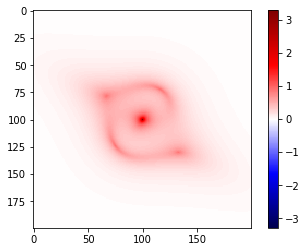

In [21]:
blankimg = CustomImage([],[],[], zl=zl, pixnum=pixnum, pixsize=pixsize)
autoshow(blankimg.image)
blankimg.calc_div_curl_5pt();

In [89]:
%%time
myimg_sub.calc_div_curl_5pt();

CPU times: user 19min 57s, sys: 124 ms, total: 19min 57s
Wall time: 19min 57s


(array([[0.19604638, 0.19656374, 0.19740918, ..., 0.38282176, 0.38057552,
         0.37804693],
        [0.19725373, 0.19773113, 0.19860556, ..., 0.38923903, 0.38388404,
         0.38065471],
        [0.19817527, 0.19891954, 0.19981876, ..., 0.39153471, 0.38631557,
         0.38302922],
        ...,
        [0.38438596, 0.38655403, 0.38829802, ..., 0.2013461 , 0.20040846,
         0.19948113],
        [0.38343609, 0.38686181, 0.38861236, ..., 0.20015656, 0.1992301 ,
         0.19831373],
        [0.38183147, 0.38917231, 0.39129713, ..., 0.19898126, 0.19806581,
         0.19716021]]),
 array([[ 7.79760237e-05,  1.63543402e-05,  9.67239124e-07, ...,
         -2.97363705e-04, -1.26499287e-05,  3.02166792e-05],
        [-1.54943023e-04,  1.47383256e-06,  9.15929054e-07, ...,
         -3.46454122e-05,  3.37818064e-04,  1.55510802e-05],
        [ 1.68877287e-05, -1.22110067e-05,  1.03938118e-06, ...,
          8.57695189e-05, -3.28604891e-04, -2.13108820e-05],
        ...,
        [ 3.841149

Text(0.5, 1.0, '$\\kappa_{sub}$ (single plane, CDM)')

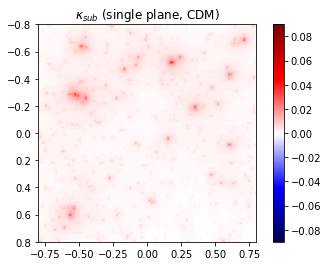

In [90]:
autoshow(myimg_sub.divmat - blankimg.divmat, ext=ext, vmax=.09)
plt.title(r'$\kappa_{sub}$ (single plane, CDM)')
#plt.savefig('imgs/feb11_subs_only_r1e-4adj.png')

In [91]:
#np.save('files/convmat_5to8_birrer.npy', 0.5*(myimg_sub.divmat - blankimg.divmat))

In [62]:
#np.save('files/convmat_subonly_10xbirrer.npy', 0.5*(myimg_sub.divmat - blankimg.divmat))

In [91]:
#np.save('files/convmat_subonly_theta1.npy', 0.5*(myimg_sub.divmat - blankimg.divmat))

### Next, try projection map

In [22]:
# Populate the interlopers in projection (middle picture in Fig 2 of Birrer's paper)

np.random.seed(145)
n_planes = 10

xs, ys, redshifts, masses = [], [], [], []
mass_sheets = []
#xyext = ext

# Interlopers!
z_planes = np.linspace(.01,.99,n_planes)
area_proportions = [double_cone(z)**2 for z in z_planes]
area_sum = np.sum(area_proportions)

for i, z_plane in enumerate(z_planes):
    rv_nums = poisson.rvs(avg_nums_interlopers * area_proportions[i] / area_sum)
    xyext = ext # * double_cone_angle(z_plane)
    # ^- I thought about multiplying this by 1.5 so we don't get weird boundary effects
    #print(rv_nums)
    for mass, num in zip(mass_bins_interlopers, rv_nums):
        for i in range(num):
            xs.append(np.random.uniform(-xyext,xyext))
            ys.append(np.random.uniform(-xyext,xyext))
            redshifts.append(zl)
            masses.append(mass)
            mass_sheets.append(True)
print('number of interlopers', len(xs))

# # Subhalos!
# rv_nums = poisson.rvs(avg_nums_sub) if len(avg_nums_sub) > 1 else [poisson.rvs(avg_nums_sub)]
# xyext = ext
# for mass, num in zip(mass_bins_sub, rv_nums):
#     for i in range(num):
#         xs.append(np.random.uniform(-xyext,xyext))
#         ys.append(np.random.uniform(-xyext,xyext))
#         redshifts.append(zl)
#         masses.append(mass)
#         mass_sheets.append(False)
# print('number of interlopers + subhalos', len(xs))

number of interlopers 605


In [27]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [24]:
%%time
myimg_proj = CustomImage(xs,ys,redshifts, zl=zl, m=masses,
                         pixnum=pixnum, pixsize=pixsize,
                         mass_sheets=mass_sheets, main_theta=1.0)

initialized LensModel
populated kwargs_lens
sorted kwargs_lens
about to initialize ImageModel
about to generate image
done
CPU times: user 6.18 s, sys: 48 ms, total: 6.23 s
Wall time: 6.09 s


In [ ]:
%%time
myimg_proj.alphamat_x = np.zeros((pixnum, pixnum))
myimg_proj.alphamat_y = np.zeros((pixnum, pixnum))
myimg_proj.calc_alpha_pixel(0,0)

In [113]:
%%time
myimg_proj.calc_div_curl_5pt();

CPU times: user 10min 55s, sys: 64 ms, total: 10min 55s
Wall time: 10min 55s


(array([[0.64724788, 0.65018768, 0.65315531, ..., 1.2591054 , 1.25406318,
         1.24897236],
        [0.65101901, 0.65399794, 0.65700607, ..., 1.2671415 , 1.26194499,
         1.25670147],
        [0.6548385 , 0.65786212, 0.66092048, ..., 1.27519076, 1.26983656,
         1.26443709],
        ...,
        [1.26698397, 1.27258151, 1.27812458, ..., 0.66761254, 0.66452545,
         0.66146814],
        [1.25932575, 1.26476855, 1.27016161, ..., 0.66366297, 0.66061154,
         0.65758937],
        [1.25169245, 1.25698207, 1.26222349, ..., 0.65976081, 0.65674438,
         0.6537567 ]]),
 array([[ 4.67402599e-08,  1.32715947e-07,  1.63768034e-07, ...,
         -3.30866237e-09, -2.62601865e-09, -2.13456000e-09],
        [ 5.48947812e-09,  2.71120434e-07,  6.21291026e-07, ...,
         -2.79752263e-09, -2.12032822e-09, -1.67963083e-09],
        [-2.57858074e-07,  5.97564972e-08,  2.39936354e-06, ...,
         -1.86300281e-09, -1.35685560e-09, -1.07000747e-09],
        ...,
        [-6.229214

In [114]:
blankimg = CustomImage([], [], [], zl=zl, m=[], 
                       pixnum=pixnum, pixsize=pixsize, 
                       mass_sheets=[], main_theta=1.0)
blankimg.calc_div_curl_5pt();

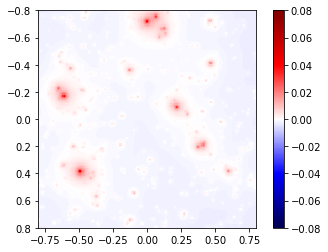

In [115]:
autoshow(myimg_proj.divmat-blankimg.divmat, ext=ext, vmax=.08)
#plt.title(r'$\kappa_{sub}$ (multi-plane Born)')
#plt.savefig('imgs/feb11_mpborn_orig.png')

In [116]:
#np.save('files/convmat_proj_5to8_press.npy', 0.5*(myimg_proj.divmat-blankimg.divmat))

In [32]:
#np.save('files/convmat_proj_theta1.npy', 0.5*(myimg_proj.divmat - blankimg.divmat))

Text(0.5, 1.0, '$\\kappa_{sub}$ (multi-plane Born): High Contrast')

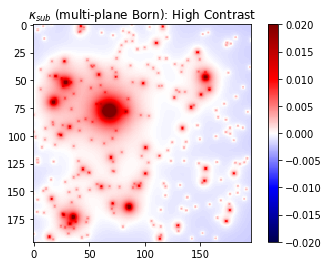

In [30]:
autoshow(myimg_proj.divmat-blankimg.divmat, vmax=.02)
plt.title(r'$\kappa_{sub}$ (multi-plane Born): High Contrast')

### Finally, the actual image:

In [230]:
# Populate the interlopers and subhalos

np.random.seed(145)
n_planes = 10

xs, ys, redshifts, masses = [], [], [], []
mass_sheets = []
#xyext = ext

z_planes = np.linspace(.01,.99,n_planes)
area_proportions = [double_cone(z)**2 for z in z_planes]
area_sum = np.sum(area_proportions)

# Interlopers
for i, z_plane in enumerate(z_planes):
    rv_nums = poisson.rvs(avg_nums_interlopers * area_proportions[i] / area_sum)
    xyext = ext * double_cone_angle(z_plane)
    # ^- I thought about multiplying this by 1.5 so we don't get weird boundary effects
    #print(rv_nums)
    for mass, num in zip(mass_bins_interlopers, rv_nums):
        for i in range(num):
            xs.append(np.random.uniform(-xyext,xyext))
            ys.append(np.random.uniform(-xyext,xyext))
            redshifts.append(z_plane)
            masses.append(mass)
            mass_sheets.append(True)
print('number of interlopers', len(xs))
# Subhalos
# rv_nums = poisson.rvs(avg_nums_sub) if len(avg_nums_sub) > 1 else [poisson.rvs(avg_nums_sub)]
# xyext = ext
# for mass, num in zip(mass_bins_sub, rv_nums):
#     for i in range(num):
#         xs.append(np.random.uniform(-xyext,xyext))
#         ys.append(np.random.uniform(-xyext,xyext))
#         redshifts.append(zl)
#         masses.append(mass)
#         mass_sheets.append(False)
# print('number of subhalos + interlopers', len(xs))

number of interlopers 395


In [231]:
from collections import Counter

In [232]:
Counter(masses)

Counter({100000.0: 105,
         143844.9888287663: 76,
         206913.808111479: 64,
         297635.14416313195: 39,
         428133.2398719396: 26,
         615848.2110660267: 26,
         885866.7904100833: 19,
         1274274.985703132: 9,
         1832980.7108324375: 8,
         2636650.8987303553: 6,
         3792690.1907322537: 3,
         5455594.781168515: 2,
         7847599.703514607: 1,
         11288378.916846883: 6,
         23357214.690901212: 1,
         33598182.862837814: 1,
         48329302.38571752: 2,
         69519279.61775605: 1})

In [118]:
myimg = CustomImage(xs, ys, redshifts, zl=zl, m=masses, 
                    pixnum=pixnum, pixsize=pixsize,
                    mass_sheets=mass_sheets, main_theta=1)

In [119]:
%%time
myimg.calc_div_curl_5pt()
0

CPU times: user 12min 5s, sys: 92 ms, total: 12min 5s
Wall time: 12min 5s


0

In [120]:
blankimg = CustomImage([], [], [], zl=zl, m=[],
                       pixnum=pixnum, pixsize=pixsize, 
                       mass_sheets=[], main_theta=1)
blankimg.calc_div_curl_5pt();

Text(0.5, 1.0, 'Difference in $\\kappa_\\mathrm{eff}$ (theta=1)')

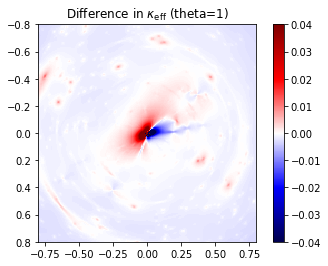

In [121]:
autoshow(0.5*(myimg.divmat - blankimg.divmat), ext=ext, vmax=.04)
plt.title(r'Difference in $\kappa_\mathrm{eff}$ (theta=1)')
#plt.savefig('imgs/feb13_final_theta1_5pt.png')

In [148]:
#np.save('files/convmat_intonlyres_5to8_press.npy', 0.5*(myimg.divmat - blankimg.divmat))

Text(0.5, 1.0, '$\\frac{1}{2}\\nabla\\times\\alpha$ (theta=1)')

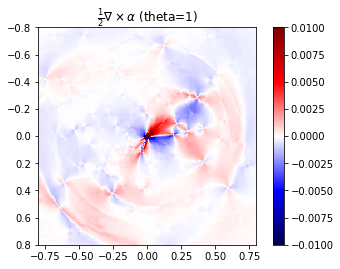

In [162]:
autoshow(0.5*(myimg.curlmat - blankimg.curlmat), ext=ext, vmax=.01)
plt.title(r'$\frac{1}{2}\nabla\times\alpha$ (theta=1)')
#plt.savefig('imgs/feb13_curl_theta1_5pt.png')

In [273]:
#np.save('files/convmat_residuals_theta1.npy', 0.5*(myimg.divmat - blankimg.divmat))#

### Extended image
So we can see past the Einstein ring.

In [163]:
# Populate the interlopers and subhalos

np.random.seed(145)
n_planes = 10

xs, ys, redshifts, masses = [], [], [], []
mass_sheets = []
#xyext = ext

z_planes = np.linspace(.01,.99,n_planes)
area_proportions = [double_cone(z)**2 for z in z_planes]
area_sum = np.sum(area_proportions)

# Interlopers
for i, z_plane in enumerate(z_planes):
    rv_nums = poisson.rvs(4 * avg_nums_interlopers * area_proportions[i] / area_sum)
    xyext = 2*ext * double_cone_angle(z_plane)
    for mass, num in zip(mass_bins_interlopers, rv_nums):
        for i in range(num):
            xs.append(np.random.uniform(-xyext,xyext))
            ys.append(np.random.uniform(-xyext,xyext))
            redshifts.append(z_plane)
            masses.append(mass)
            mass_sheets.append(True)
print('number of interlopers', len(xs))
# # Subhalos
# rv_nums = poisson.rvs(4 * avg_nums_sub) if len(avg_nums_sub) > 1 else [poisson.rvs(4 * avg_nums_sub)]
# xyext = 2*ext
# for mass, num in zip(mass_bins_sub, rv_nums):
#     for i in range(num):
#         xs.append(np.random.uniform(-xyext,xyext))
#         ys.append(np.random.uniform(-xyext,xyext))
#         redshifts.append(zl)
#         masses.append(mass)
#         mass_sheets.append(False)
# print('number of subhalos + interlopers', len(xs))

number of interlopers 1607


In [164]:
ext_extended = 2*ext
print('ext_extended', ext_extended)

ext_extended 1.6


In [165]:
myimg_extended = CustomImage(xs, ys, redshifts, zl=zl, m=masses, pixnum=pixnum, pixsize=pixsize*2, mass_sheets=mass_sheets, main_theta=1.0)

In [166]:
%%time
myimg_extended.calc_div_curl_5pt()
0
#load files/myimg_extended.npy instead!

CPU times: user 51min 28s, sys: 452 ms, total: 51min 29s
Wall time: 3h 9min 41s


0

In [167]:
blankimg_extended = CustomImage([], [], [], zl=zl, m=[], pixnum=pixnum, pixsize=pixsize*2, mass_sheets=mass_sheets, main_theta=1.0)
blankimg_extended.calc_div_curl_5pt()
0

0

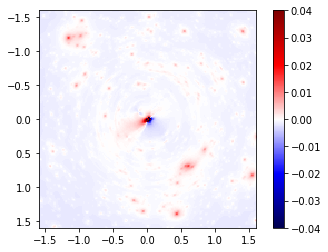

In [168]:
autoshow(0.5*(myimg_extended.divmat - blankimg_extended.divmat), ext=ext_extended, vmax=0.04)

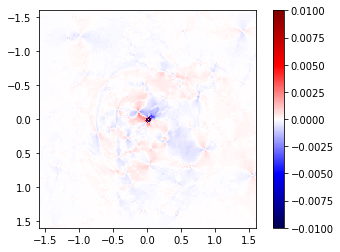

In [174]:
autoshow(0.5*(myimg_extended.curlmat - blankimg_extended.curlmat), ext=ext_extended, vmax=0.01)

In [151]:
#np.save('files/myimg_extended.npy', myimg_extended)

In [169]:
convmat = 0.5*(myimg_extended.divmat - blankimg_extended.divmat)

In [170]:
#np.save('files/convmat_extended_intonlyres_5to8_press.npy', convmat)

### Mask
TODO: Figure out proper width of mask

In [175]:
def isinmask(xpix, ypix, r, dr, pixsize, pixnum):
    # r is the einstein radius, and we take pixels within r +- dr
    # (sharp cutoff)
    npix = np.sqrt((xpix-pixnum/2)**2 + (ypix-pixnum/2)**2)
    pixdist = npix * pixsize
    return (r - dr < pixdist < r + dr)

def isinmask_smooth(xpix, ypix, r, dr, pixsize, pixnum):
    # r is the einstein radius, and we take pixels within r +- dr
    # gaussian smoothing
    npix = np.sqrt((xpix-pixnum/2)**2 + (ypix-pixnum/2)**2)
    pixdist = npix * pixsize
    return np.exp(-(pixdist-r)**2/(2*dr**2))

In [178]:
mask_smooth = np.zeros((196,196))
for i in range(196):
    for j in range(196):
        mask_smooth[i,j] = isinmask_smooth(i,j, 1.0, 0.1, pixsize*2, pixnum-4)

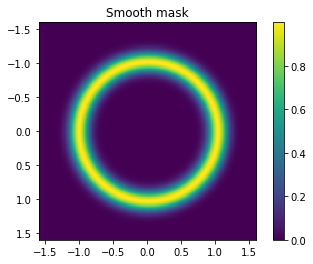

In [179]:
plt.imshow(mask_smooth, extent=[-ext_extended,ext_extended,ext_extended,-ext_extended])
plt.title('Smooth mask')
plt.colorbar()

In [180]:
masked_convmat = convmat * mask_smooth

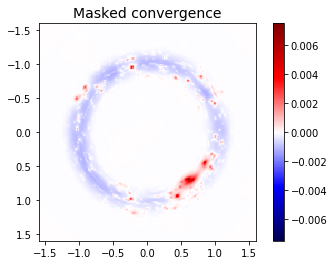

In [181]:
autoshow(masked_convmat, ext=ext_extended, vmax=None)
plt.title('Masked convergence', size=14)
#plt.savefig('imgs/feb18_masked_convergence.png')

In [214]:
mask_coverage = np.sum(mask_smooth) / len(mask_smooth)**2
print('mask coverage', mask_coverage)

mask coverage 0.16014658927168757


In [183]:
#np.save('files/masked_convmat_test2.npy', masked_convmat)

## Fourier transform

In [186]:
# Calculate values to plug into Ana's Fourier Transform code
print('phys width kpc', phys_width_kpc)
residuals = myimg.divmat - blankimg.divmat
print('shape', residuals.shape)
print('sigma_cr', sigma_cr(zl,zs).to(u.Msun/u.kpc**2))

phys width kpc 9.713163759014881
shape (196, 196)
sigma_cr 3116549930.8938007 solMass / kpc2


Why does `side` have to be an integer? It is the length of the image in kpc.

In [39]:
!python2 make_mask.py --pix_num=196 --side=10

### Subhalo-only
First, we deal with the subhalo-only case.

In [65]:
# subhalos only, using Birrer mass function (Sig_sub = .012), mass range 5.7-10
!python2 power_spectrum.py \
--conv_file1 files/convmat_subonly_birrer.npy \ 
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name subImg \
# --z 0.2 \
# --m_high 1e-2 \
# --m_low 1e-4 \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/convmat_subonly_birrer.npy
k saved in files/ksubImg_095_196_10.txt
saved files/ind_curves_subImg_095_196_10


In [97]:
klist_sub = np.loadtxt('files/ksubImg_095_196_10.txt')
plist_sub = np.load('files/ind_curves_subImg_095_196_10.npy')

In [141]:
# subhalos only, using Ana's approx mass function (Sig_sub = .120), mass range 5.7-10
!python2 power_spectrum.py \
--conv_file1 files/convmat_subonly_10xbirrer.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name subBigsigImg \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/convmat_subonly_10xbirrer.npy
k saved in files/ksubBigsigImg_095_196_10.txt
saved files/ind_curves_subBigsigImg_095_196_10


In [142]:
klist_sub_bigsig = np.loadtxt('files/ksubBigsigImg_095_196_10.txt')
plist_sub_bigsig = np.load('files/ind_curves_subBigsigImg_095_196_10.npy')

In [92]:
!python2 power_spectrum.py \
--conv_file1 files/convmat_subonly_5to8_birrer.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name sub58Img \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/convmat_subonly_5to8_birrer.npy
k saved in files/ksub58Img_095_196_10.txt
saved files/ind_curves_sub58Img_095_196_10


In [93]:
klist_sub58 = np.loadtxt('files/ksub58Img_095_196_10.txt')
plist_sub58 = np.load('files/ind_curves_sub58Img_095_196_10.npy')

In [137]:
ana_power = np.array([[0.01, 0.018724], [0.0125893, 0.0184922], [0.0158489, 
  0.0181708], [0.0199526, 0.0177327], [0.0251189, 
  0.0171472], [0.0316228, 0.0163835], [0.0398107, 
  0.0154165], [0.0501187, 0.0142333], [0.0630957, 
  0.0128425], [0.0794328, 0.0112805], [0.1, 0.00961281], [0.125893, 
  0.00792626], [0.158489, 0.00631364], [0.199526, 
  0.00485526], [0.251189, 0.00360484], [0.316228, 
  0.00258481], [0.398107, 0.00179032], [0.501187, 
  0.00119788], [0.630957, 0.000774238], [0.794328, 0.000483482], [1., 
  0.000291846], [1.25893, 0.000170464], [1.58489, 
  0.0000964939], [1.99526, 0.0000530466], [2.51189, 
  0.00002839], [3.16228, 0.0000148303], [3.98107, 
  7.58028e-6], [5.01187, 3.79931e-6], [6.30957, 
  1.87031e-6], [7.94328, 9.052e-7], [10., 
  4.30896e-7], [12.5893, 2.01718e-7], [15.8489, 
  9.28259e-8], [19.9526, 4.19686e-8], [25.1189, 
  1.86367e-8], [31.6228, 8.12916e-9], [39.8107, 
  3.48545e-9], [50.1187, 1.47091e-9], [63.0957, 
  6.12139e-10], [79.4328, 2.51781e-10], [100., 
  1.02596e-10], [125.893, 4.15081e-11], [158.489, 
  1.6706e-11], [199.526, 6.69906e-12], [251.189, 
  2.67958e-12], [316.228, 1.07002e-12], [398.107, 
  4.26819e-13], [501.187, 1.70132e-13], [630.957, 
  6.77844e-14], [794.328, 2.6999e-14], [1000., 1.07519e-14]]) # mass range 10^5.7-10^10

ana_power_58 = np.array([[0.01, 0.000121185], [0.0125893, 0.000121059], [0.0158489, 
  0.000120874], [0.0199526, 0.000120602], [0.0251189, 
  0.000120206], [0.0316228, 0.000119633], [0.0398107, 
  0.000118812], [0.0501187, 0.000117646], [0.0630957, 
  0.000116014], [0.0794328, 0.000113762], [0.1, 
  0.000110709], [0.125893, 0.00010666], [0.158489, 
  0.000101429], [0.199526, 0.0000948767], [0.251189, 
  0.0000869609], [0.316228, 0.0000777909], [0.398107, 
  0.0000676595], [0.501187, 0.0000570328], [0.630957, 
  0.0000464842], [0.794328, 0.0000365854], [1., 
  0.0000277947], [1.25893, 0.0000203853], [1.58489, 
  0.0000144367], [1.99526, 9.87261e-6], [2.51189, 
  6.51843e-6], [3.16228, 4.15445e-6], [3.98107, 
  2.55575e-6], [5.01187, 1.518e-6], [6.30957, 
  8.71092e-7], [7.94328, 4.83466e-7], [10., 
  2.59889e-7], [12.5893, 1.35523e-7], [15.8489, 
  6.866e-8], [19.9526, 3.38423e-8], [25.1189, 
  1.62472e-8], [31.6228, 7.60478e-9], [39.8107, 
  3.47383e-9], [50.1187, 1.55042e-9], [63.0957, 
  6.77127e-10], [79.4328, 2.89962e-10], [100., 
  1.22047e-10], [125.893, 5.0632e-11], [158.489, 
  2.0762e-11], [199.526, 8.43781e-12], [251.189, 
  3.40664e-12], [316.228, 1.36896e-12], [398.107, 
  5.48347e-13], [501.187, 2.19171e-13], [630.957, 
  8.74764e-14], [794.328, 3.48818e-14], [1000., 1.39011e-14]])

ana_power_57 = np.array([[0.01, 9.58504e-6], [0.0125893, 9.58239e-6], [0.0158489, 
  9.57843e-6], [0.0199526, 9.57254e-6], [0.0251189, 
  9.56378e-6], [0.0316228, 9.55085e-6], [0.0398107, 
  9.53184e-6], [0.0501187, 9.50408e-6], [0.0630957, 
  9.46382e-6], [0.0794328, 9.40593e-6], [0.1, 
  9.3235e-6], [0.125893, 9.20751e-6], [0.158489, 
  9.04659e-6], [0.199526, 8.8271e-6], [0.251189, 
  8.53381e-6], [0.316228, 8.15139e-6], [0.398107, 
  7.66713e-6], [0.501187, 7.07472e-6], [0.630957, 
  6.37849e-6], [0.794328, 5.59678e-6], [1., 
  4.76248e-6], [1.25893, 3.91923e-6], [1.58489, 
  3.11363e-6], [1.99526, 2.38599e-6], [2.51189, 
  1.76326e-6], [3.16228, 1.25663e-6], [3.98107, 
  8.63515e-7], [5.01187, 5.71916e-7], [6.30957, 
  3.64875e-7], [7.94328, 2.24108e-7], [10., 
  1.3246e-7], [12.5893, 7.53291e-8], [15.8489, 
  4.12263e-8], [19.9526, 2.17257e-8], [25.1189, 
  1.10356e-8], [31.6228, 5.41074e-9], [39.8107, 
  2.56538e-9], [50.1187, 1.1789e-9], [63.0957, 
  5.26531e-10], [79.4328, 2.29293e-10], [100., 
  9.77068e-11], [125.893, 4.08937e-11], [158.489, 
  1.68728e-11], [199.526, 6.88635e-12], [251.189, 
  2.78821e-12], [316.228, 1.12255e-12], [398.107, 
  4.50201e-13], [501.187, 1.80085e-13], [630.957, 
  7.19131e-14], [794.328, 2.86851e-14], [1000., 1.14339e-14]])

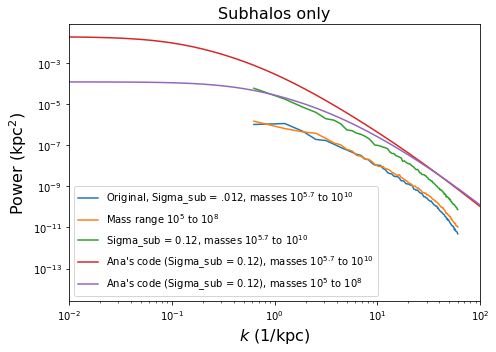

In [257]:
plt.figure(figsize=(7,5))

plt.loglog(klist_sub, plist_sub[0], label='Original, Sigma_sub = .012, masses $10^{5.7}$ to $10^{10}$')
plt.loglog(klist_sub58, plist_sub58[0], label='Mass range $10^5$ to $10^8$')
plt.loglog(klist_sub10, plist_sub10[0], label='Sigma_sub = 0.12, masses $10^{5.7}$ to $10^{10}$')
plt.loglog(ana_power[:,0], ana_power[:,1], label='Ana\'s code (Sigma_sub = 0.12), masses $10^{5.7}$ to $10^{10}$')
plt.loglog(ana_power_58[:,0], ana_power_58[:,1], label='Ana\'s code (Sigma_sub = 0.12), masses $10^5$ to $10^8$')
#plt.loglog(ana_power_57[:,0], ana_power_57[:,1], label='Ana\'s code (Sigma_sub = 0.12), masses $10^5$ to $10^7$')
# plt.loglog(klist_proj, plist_proj[0], label='Projection (column 2)')
# plt.loglog(klist, plist[0], label='Residual (column 3)')
#plt.axvline(np.pi * pixnum / phys_width_kpc, color='k', label='Pixel resolution')
#plt.axvline(2* np.pi / phys_width_kpc, color='k')

plt.xlim(1e-2,1e2)
#plt.ylim(1e-11,1e-2)
plt.xlabel(r'$k$ (1/kpc)', size=16)
plt.ylabel(r'Power (kpc$^2$)', size=16)
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend()
plt.title('Subhalos only', size=16)
plt.tight_layout()


#plt.savefig('imgs/feb18_sps.png')

# TODO: do the same thing with interlopers

Seems like things are making sense to within an order of magnitude. It would be nice to check whether the lenstronomy function plateaus where it should (should probably speed-up code first).

## Interloper only
Then we deal with the interloper-only case.

In [149]:
!python2 power_spectrum.py \
--conv_file1 files/convmat_intonlyproj_5to8_press.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name intproj58Img \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/convmat_intonlyproj_5to8_press.npy
k saved in files/kintproj58Img_095_196_10.txt
saved files/ind_curves_intproj58Img_095_196_10


In [156]:
klist_intproj58 = np.loadtxt('files/kintproj58Img_095_196_10.txt')
plist_intproj58 = np.load('files/ind_curves_intproj58Img_095_196_10.npy')

In [151]:
!python2 power_spectrum.py \
--conv_file1 files/convmat_intonlyres_5to8_press.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 10 \
--name int58Img \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/convmat_intonlyres_5to8_press.npy
k saved in files/kint58Img_095_196_10.txt
saved files/ind_curves_int58Img_095_196_10


In [157]:
klist_int58 = np.loadtxt('files/kint58Img_095_196_10.txt')
plist_int58 = np.load('files/ind_curves_int58Img_095_196_10.npy')

In [209]:
!python2 power_spectrum.py \
--conv_file1 files/masked_convmat_test2.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 19 \
--name maskint58Img \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/masked_convmat_test2.npy
k saved in files/kmaskint58Img_095_196_19.txt
saved files/ind_curves_maskint58Img_095_196_19


In [211]:
klist_maskint58 = np.loadtxt('files/kmaskint58Img_095_196_19.txt')
plist_maskint58 = np.load('files/ind_curves_maskint58Img_095_196_19.npy')

In [240]:

interloper_ps_58 = np.array([[1.00000000e-02, 3.22232012e-06],
       [1.48735211e-02, 3.21507983e-06],
       [2.21221629e-02, 3.20154090e-06],
       [3.29034456e-02, 3.17613036e-06],
       [4.89390092e-02, 3.12842422e-06],
       [7.27895384e-02, 3.04624463e-06],
       [1.08263673e-01, 2.90881056e-06],
       [1.61026203e-01, 2.69299732e-06],
       [2.39502662e-01, 2.38792327e-06],
       [3.56224789e-01, 1.99119358e-06],
       [5.29831691e-01, 1.55329895e-06],
       [7.88046282e-01, 1.11810013e-06],
       [1.17210230e+00, 7.33494143e-07],
       [1.74332882e+00, 4.48791068e-07],
       [2.59294380e+00, 2.51806265e-07],
       [3.85662042e+00, 1.26840228e-07],
       [5.73615251e+00, 5.98130968e-08],
       [8.53167852e+00, 2.61382382e-08],
       [1.26896100e+01, 1.02358474e-08],
       [1.88739182e+01, 3.77354276e-09],
       [2.80721620e+01, 1.30751243e-09],
       [4.17531894e+01, 4.14453723e-10],
       [6.21016942e+01, 1.24127565e-10],
       [9.23670857e+01, 3.51162802e-11],
       [1.37382380e+02, 9.48718774e-12],
       [2.04335972e+02, 2.36104923e-12],
       [3.03919538e+02, 5.66570704e-13],
       [4.52035366e+02, 1.35832931e-13],
       [6.72335754e+02, 2.89591909e-14],
       [1.00000000e+03, 6.15926576e-15]]) # calculated in `analytic_interlopers.ipynb` in the cannon Jupyter notebook

interloper_ps_58_nomeff = np.array([[1.00000000e-02, 3.68237308e-06],
       [1.48735211e-02, 3.67449096e-06],
       [2.21221629e-02, 3.65955464e-06],
       [3.29034456e-02, 3.63176907e-06],
       [4.89390092e-02, 3.57964708e-06],
       [7.27895384e-02, 3.48960056e-06],
       [1.08263673e-01, 3.33855291e-06],
       [1.61026203e-01, 3.10084113e-06],
       [2.39502662e-01, 2.76269966e-06],
       [3.56224789e-01, 2.32054998e-06],
       [5.29831691e-01, 1.82730397e-06],
       [7.88046282e-01, 1.33178185e-06],
       [1.17210230e+00, 8.87310205e-07],
       [1.74332882e+00, 5.52715362e-07],
       [2.59294380e+00, 3.16349437e-07],
       [3.85662042e+00, 1.64408070e-07],
       [5.73615251e+00, 8.00716713e-08],
       [8.53167852e+00, 3.62159177e-08],
       [1.26896100e+01, 1.48866230e-08],
       [1.88739182e+01, 5.78415513e-09],
       [2.80721620e+01, 2.09925984e-09],
       [4.17531894e+01, 7.14184113e-10],
       [6.21016942e+01, 2.25960170e-10],
       [9.23670857e+01, 6.72684015e-11],
       [1.37382380e+02, 1.95071435e-11],
       [2.04335972e+02, 5.06675520e-12],
       [3.03919538e+02, 1.25664126e-12],
       [4.52035366e+02, 3.22489475e-13],
       [6.72335754e+02, 7.02274494e-14],
       [1.00000000e+03, 1.45974563e-14]])

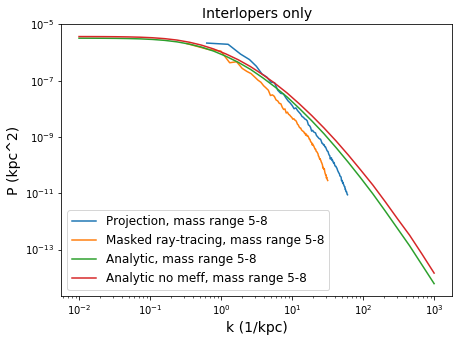

In [256]:
plt.figure(figsize=(7,5))
plt.title('Interlopers only', size=14)
plt.loglog(klist_intproj58, plist_intproj58[0], label='Projection, mass range 5-8')
#plt.loglog(klist_int58, plist_int58[0], label='Full ray-tracing, mass range 5-8')
plt.loglog(klist_maskint58, plist_maskint58[0]/mask_coverage, label='Masked ray-tracing, mass range 5-8')
plt.loglog(interloper_ps_58[:,0], interloper_ps_58[:,1], label='Analytic, mass range 5-8')
plt.loglog(interloper_ps_58_nomeff[:,0], interloper_ps_58_nomeff[:,1], label='Analytic no meff, mass range 5-8')

plt.legend(loc='lower left', fontsize=12)

plt.xlabel('k (1/kpc)', size=14)
plt.ylabel('P (kpc^2)', size=14)

#plt.savefig('imgs/feb19_ps_interloper.png')

In [243]:
plist_intproj58[0][0]

2.161711962452055e-06

All together now!

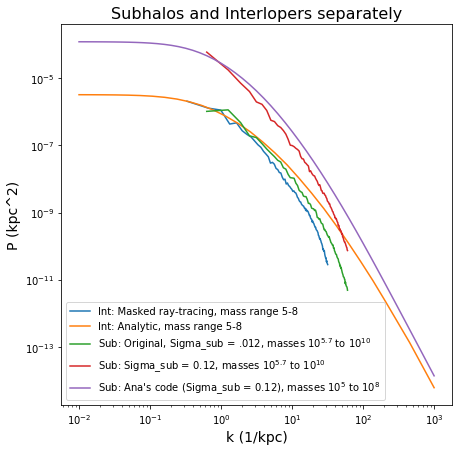

In [259]:
plt.figure(figsize=(7,7))

plt.title('Subhalos and Interlopers separately', fontsize=16)
#plt.loglog(klist_intproj58, plist_intproj58[0], label='Projection, mass range 5-8')
#plt.loglog(klist_int58, plist_int58[0], label='Full ray-tracing, mass range 5-8')
plt.loglog(klist_maskint58, plist_maskint58[0]/mask_coverage, label='Int: Masked ray-tracing, mass range 5-8')
plt.loglog(interloper_ps_58[:,0], interloper_ps_58[:,1], label='Int: Analytic, mass range 5-8')
#plt.loglog(interloper_ps_58_nomeff[:,0], interloper_ps_58_nomeff[:,1], label='Analytic no meff, mass range 5-8')
plt.loglog(klist_sub, plist_sub[0], label='Sub: Original, Sigma_sub = .012, masses $10^{5.7}$ to $10^{10}$')
#plt.loglog(klist_sub58, plist_sub58[0], label='Mass range $10^5$ to $10^8$')
plt.loglog(klist_sub10, plist_sub10[0], label='Sub: Sigma_sub = 0.12, masses $10^{5.7}$ to $10^{10}$')
#plt.loglog(ana_power[:,0], ana_power[:,1], label='Ana\'s code (Sigma_sub = 0.12), masses $10^{5.7}$ to $10^{10}$')
plt.loglog(ana_power_58[:,0], ana_power_58[:,1], label='Sub: Ana\'s code (Sigma_sub = 0.12), masses $10^5$ to $10^8$')

plt.legend(loc='lower left')

plt.xlabel('k (1/kpc)', size=14)
plt.ylabel('P (kpc^2)', size=14)

#plt.savefig('imgs/feb19_ps_both.png')

Subhalo plateau is roughly 40x stronger:

In [267]:
ana_power_58[0][1] / interloper_ps_58[0][1]

37.60799532232694

# Old cells

In [108]:
# !python2 power_spectrum.py \
# --conv_file1 files/convmat_residuals_theta1.npy \
# --kdir files/ \
# --psdir files/ \
# --pix_num 196 \
# --side 10 \
# --name residImg \
# # --z 0.2 \
# # --m_high 1e-2 \
# # --m_low 1e-4 \
# --num_proj 1 \
# --sigma_crit 3.11e9

convergence maps loaded:
files/convmat_residuals_theta1.npy
k saved in files/kresidImg_095_196_10.txt
saved files/ind_curves_residImg_095_196_10


In [109]:
# klist = np.loadtxt('files/kresidImg_095_196_10.txt')
# plist = np.load('files/ind_curves_residImg_095_196_10.npy')

In [33]:
# !python2 power_spectrum.py \
# --conv_file1 files/convmat_proj_theta1.npy \
# --kdir files/ \
# --psdir files/ \
# --pix_num 196 \
# --side 10 \
# --name projImg \
# # --z 0.2 \
# # --m_high 1e-2 \
# # --m_low 1e-4 \
# --num_proj 1 \
# --sigma_crit 3.11e9

convergence maps loaded:
files/convmat_proj_theta1.npy
k saved in files/kprojImg_095_196_10.txt
saved files/ind_curves_projImg_095_196_10


In [34]:
# klist_proj = np.loadtxt('files/kprojImg_095_196_10.txt')
# plist_proj = np.load('files/ind_curves_projImg_095_196_10.npy')

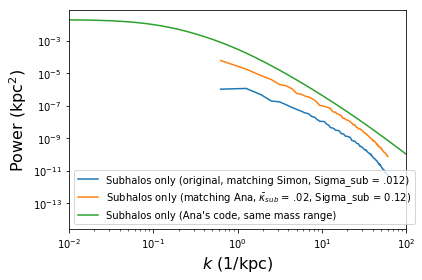

In [84]:
# plt.loglog(klist_sub, plist_sub[0], label='Subhalos only (original, matching Simon, Sigma_sub = .012)')
# plt.loglog(klist_sub10, plist_sub10[0], label='Subhalos only (matching Ana, $\\bar\\kappa_{sub}$ = .02, Sigma_sub = 0.12)')
# plt.loglog(ana_power[:,0], ana_power[:,1], label='Subhalos only (Ana\'s code, same mass range)')
# # plt.loglog(klist_proj, plist_proj[0], label='Projection (column 2)')
# # plt.loglog(klist, plist[0], label='Residual (column 3)')
# plt.xlim(1e-2,1e2)
# #plt.ylim(1e-11,1e-2)
# plt.xlabel(r'$k$ (1/kpc)', size=16)
# plt.ylabel(r'Power (kpc$^2$)', size=16)
# plt.legend(loc='lower left')
# plt.tight_layout()

# #plt.savefig('imgs/feb15_sps.png')

In [103]:
1/(phys_width_kpc / pixnum)

20.590613415158174

In [175]:
phys_width_kpc * 2

19.426327518029762

In [185]:
!python2 power_spectrum.py \
--conv_file1 files/masked_convmat_test.npy \
--kdir files/ \
--psdir files/ \
--pix_num 196 \
--side 19 \
--name maskTest2 \
# --z 0.2 \
# --m_high 1e-2 \
# --m_low 1e-4 \
--num_proj 1 \
--sigma_crit 3.11e9

convergence maps loaded:
files/masked_convmat_test.npy
k saved in files/kmaskTest2_095_196_19.txt
saved files/ind_curves_maskTest2_095_196_19


In [186]:
klist_mask_test = np.loadtxt('files/kmaskTest2_095_196_19.txt')
plist_mask_test = np.load('files/ind_curves_maskTest2_095_196_19.npy')

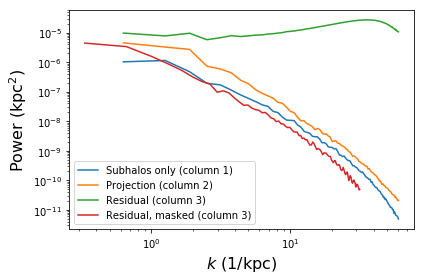

In [197]:
plt.loglog(klist_sub, plist_sub[0], label='Subhalos only (column 1)')
plt.loglog(klist_proj, plist_proj[0], label='Projection (column 2)')
plt.loglog(klist, plist[0], label='Residual (column 3)')
plt.loglog(klist_mask_test, plist_mask_test[0], label='Residual, masked (column 3)')
plt.xlabel(r'$k$ (1/kpc)', size=16)
plt.ylabel(r'Power (kpc$^2$)', size=16)
plt.tight_layout()
plt.legend()
plt.savefig(r'imgs/feb13_ps_withmask.png')

In [35]:
analytic_results = np.load('files/ps_interlopers.npy')

In [206]:
#plt.loglog(klist_sub, plist_sub[0], label='Subhalos only (column 1)')
plt.loglog(klist_proj, plist_proj[0], label='Projection (column 2)')
# plt.loglog(klist, plist[0], label='Residual (column 3)')
# plt.loglog(klist_mask_test, plist_mask_test[0], label='Residual, masked (column 3)')
plt.loglog(analytic_results[:,0], analytic_results[:,1], label='Numerical integration (x 10^-3)')
plt.xlabel(r'$k$ (1/kpc)', size=16)
plt.ylabel(r'Power (kpc$^2$)', size=16)
plt.tight_layout()
plt.legend()
plt.savefig(r'imgs/feb13_ps_withmask.png')

NameError: name 'klist_proj' is not defined

In [207]:
analytic_results[:,1]

array([3.22232012e-03, 3.21507983e-03, 3.20154090e-03, 3.17613036e-03,
       3.12842422e-03, 3.04624463e-03, 2.90881056e-03, 2.69299732e-03,
       2.38792327e-03, 1.99119358e-03, 1.55329895e-03, 1.11810013e-03,
       7.33494143e-04, 4.48791068e-04, 2.51806265e-04, 1.26840228e-04,
       5.98130968e-05, 2.61382382e-05, 1.02358474e-05, 3.77354276e-06,
       1.30751243e-06, 4.14102937e-07, 1.23458410e-07, 3.49829147e-08,
       9.41169417e-09, 2.35524426e-09, 5.61420381e-10, 1.33919274e-10,
       2.91689143e-11, 6.12572158e-12])

In [44]:
# np.save('files/full_alpha.npy', [myimg.alphamat_x, myimg.alphamat_y])

# np.save('files/macro_alpha.npy', [blankimg.alphamat_x, blankimg.alphamat_y])

# np.save('files/diff_alpha.npy', [myimg.alphamat_x - blankimg.alphamat_x, myimg.alphamat_y - blankimg.alphamat_y])

In [41]:
# autoshow(myimg.divmat - blankimg.divmat - .003, ext=ext, vmax=.08)
# plt.title(r'$\kappa_\mathrm{eff}$ (theta=1) + offset')
# plt.savefig('imgs/feb11_final_theta1_offset.png')

---

In [ ]:
autoshow(myimg.image)

In [ ]:
autoshow(myimg.image - blankimg.image, vmax=5)

In [ ]:
flat_redshifts = [zl] * len(xs)
flatimg = CustomImage(xs, ys, flat_redshifts, zl=zl, m=masses, pixnum=pixnum, pixsize=pixsize)

In [ ]:
autoshow(flatimg.image - blankimg.image)

In [ ]:
# vmin = np.min(myimg.image - blankimg.image)
# vmax = np.max(myimg.image - blankimg.image)
# vmin = min(vmin, -vmax)
# vmax = max(vmax, -vmin)

# plt.imshow(myimg.image - blankimg.image, vmin=vmin, vmax=vmax, cmap='seismic')
# plt.colorbar()
# plt.scatter([myimg.x_to_pix(x,z) for x,z in zip(xs, redshifts)],
#             [myimg.x_to_pix(y,z) for y,z in zip(ys, redshifts)], color='black', marker='+', label='interloper/subhalo')
# plt.scatter([myimg.x_to_pix(0)], [myimg.x_to_pix(0)], color='black', label='main lens')

# leg = plt.legend()
# #leg.get_frame().set_linewidth(3)
# leg.get_frame().set_edgecolor('k')

# plt.title('Pixel residual from substructure', size=16)

# #plt.savefig('imgs/jan26_sample_residuals.pdf')

# plt.show()

In [ ]:
# myimg.lens_model_mp.ray_shooting(0,0,myimg.kwargs_lens)
# myimg.lens_model_mp.ray_shooting(-10,0,myimg.kwargs_lens)
# myimg.pixel_grid.map_pix2coord(140, 0)

# alphamat_x = np.zeros((myimg.pixnum, myimg.pixnum))
# alphamat_y = np.zeros((myimg.pixnum, myimg.pixnum))
# alphamat_mag = np.zeros((myimg.pixnum, myimg.pixnum))
# for xpix in range(myimg.pixnum):
#     for ypix in range(myimg.pixnum):
#         image_xy = myimg.pixel_grid.map_pix2coord(xpix, ypix) # in angle units
#         source_xy = myimg.lens_model_mp.ray_shooting(image_xy[0], image_xy[1], myimg.kwargs_lens)
#         alphamat_x[xpix,ypix] = image_xy[0] - source_xy[0]
#         alphamat_y[xpix,ypix] = image_xy[1] - source_xy[1]
#         alphatmat_mag = np.sqrt(alphamat_x[xpix,ypix]**2 + alphamat_y[xpix,ypix]**2)

# divmat = np.gradient(alphamat_x, myimg.pixsize)[0] + np.gradient(alphamat_y, myimg.pixsize)[1]
# curlmat = np.gradient(alphamat_y, myimg.pixsize)[0] - np.gradient(alphamat_x, myimg.pixsize)[1]

In [ ]:
divmat, curlmat = myimg.calc_div_curl();

In [ ]:
divmat_blank, curlmat_blank = blankimg.calc_div_curl();

In [ ]:
divmat_flat, curlmat_flat = flatimg.calc_div_curl();

In [ ]:
np.sum(divmat) - np.sum(divmat_blank)

In [ ]:
np.sum(divmat) - np.sum(divmat_blank)

In [ ]:
np.sum(divmat_flat) - np.sum(divmat_blank)

In [ ]:
autoshow(divmat, ext=ext)

In [ ]:
autoshow(divmat - divmat_blank, vmax=3, ext=ext)

In [ ]:
autoshow(divmat - divmat_blank, vmax=3, ext=ext)
#plt.savefig('imgs/feb10_nosub_theta.3.png')

In [ ]:
autoshow(divmat - divmat_blank, vmax=.04, ext=ext)
#plt.savefig('imgs/feb4_nosub_theta.3.png')
# this particular picture showing right now (maybe not when you restart the kernel) is with mass sheets but no subhalos

In [ ]:
autoshow(divmat_flat - divmat_blank, vmax=None)

In [ ]:
autoshow(curlmat - curlmat_blank, vmax=.001)

In [ ]:
image = (divmat - divmat_blank).T
outer_image = image.copy()
for xpix in range(myimg.pixnum//2 - 2, myimg.pixnum//2 + 2):
    for ypix in range(myimg.pixnum//2 - 2, myimg.pixnum//2 + 2):
        outer_image[xpix,ypix] = 0
autoshow(image, ext=ext)
plt.show()
autoshow(outer_image, ext=ext)

In [ ]:
vmax = .08
plt.imshow(outer_image, vmin=-vmax, vmax=vmax, cmap='seismic', extent=[-ext,ext,ext,-ext])
plt.colorbar()

In [ ]:
plt.imshow(np.log10(outer_image), cmap='inferno')
plt.imshow(np.log10(-outer_image), cmap='viridis')

In [ ]:
#np.save('files/myimg_247interlopers.npy', myimg)

In [ ]:
# image_flat = (divmat_flat - divmat_blank).T
# autoshow(image_flat, ext=ext)

In [ ]:
#np.save('files/myimg247.npy', myimg)
#np.save('files/flatimg247.npy', flatimg)

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

ratio = 1e5
# check that title is correctly set to the ratio

#vmin = min(np.min(divmat), np.min(divmat_blank), ratio*np.min(divmat-divmat_blank))
#vmax = max(np.max(divmat), np.max(divmat_blank), ratio*np.max(divmat-divmat_blank))
vmax=8000
vmin = -vmax

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(divmat.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(divmat_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[1].set_title('Macro only')
im2 = axs[2].imshow(ratio*(divmat-divmat_blank).T, 
              vmin=vmin, vmax=vmax,
              extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[2].set_title('Difference $\\times 10^5$')

plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\cdot\vec\alpha$ (500 interlopers of mass $10^7\, M_\odot$)', size=20)

#plt.savefig('imgs/jan30_sample500_scaled.png')
plt.show()

In [ ]:
plt.imshow(np.log10(0.5*divmat_blank.T), extent=[-ext,ext,ext,-ext], cmap='inferno')
plt.colorbar()
plt.title(r'$\log_{10}$ convergence')
plt.tight_layout()
plt.savefig('imgs/jan30_logmacro.png')

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

vmin = -1e-4#min(np.min(curlmat), np.min(curlmat_blank))
vmax = 1e-4#max(np.max(curlmat), np.max(curlmat_blank))

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(curlmat.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(curlmat_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[1].set_title('Macro only')
axs[2].imshow((curlmat-curlmat_blank).T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[2].set_title('Difference')
plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\times\vec\alpha$ (200x200 pixels)', size=20)

#plt.savefig('imgs/jan27_sample20_curls.png')

plt.show()

## Test if curl pattern is a numerical error

In [ ]:
blankimg2 = CustomImage([],[],[], zl=zl,              pixnum=400, pixsize=.004)

myimg2 = CustomImage(xs, ys, redshifts, zl=zl, m=1e7, pixnum=400, pixsize=.004)

vmin = np.min(myimg2.image - blankimg2.image)
vmax = np.max(myimg2.image - blankimg2.image)
vmin = min(vmin, -vmax)
vmax = max(vmax, -vmin)

plt.imshow(myimg2.image - blankimg2.image, vmin=vmin, vmax=vmax, cmap='seismic')
plt.colorbar()
plt.scatter([myimg2.x_to_pix(x,z) for x,z in zip(xs, redshifts)],
            [myimg2.x_to_pix(y,z) for y,z in zip(ys, redshifts)], color='black', marker='+', label='interloper/subhalo')
plt.scatter([myimg2.x_to_pix(0)], [myimg2.x_to_pix(0)], color='black', label='main lens')

leg = plt.legend()
#leg.get_frame().set_linewidth(3)
leg.get_frame().set_edgecolor('k')

plt.title('Pixel residual from substructure', size=16)

#plt.savefig('imgs/jan26_sample_residuals.pdf')

plt.show()

In [ ]:
divmat2, curlmat2 = myimg2.calc_div_curl()
divmat2_blank, curlmat2_blank = blankimg2.calc_div_curl()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

ratio = 1e5
# check that title is correctly set to the ratio

#vmin = min(np.min(divmat), np.min(divmat_blank), ratio*np.min(divmat-divmat_blank))
#vmax = max(np.max(divmat), np.max(divmat_blank), ratio*np.max(divmat-divmat_blank))
vmax=100
vmin = -vmax

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(divmat2.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(divmat2_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[1].set_title('Macro only')
im2 = axs[2].imshow(ratio*(divmat2-divmat2_blank).T, 
              vmin=vmin, vmax=vmax,
              extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[2].set_title('Difference $\\times 10^5$')

plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\cdot\vec\alpha$', size=20)

#plt.savefig('imgs/jan26_sample500_divergences.png')
plt.show()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

vmin = -1e-4#min(np.min(curlmat), np.min(curlmat_blank))
vmax = 1e-4#max(np.max(curlmat), np.max(curlmat_blank))

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(curlmat2.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(curlmat2_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[1].set_title('Macro only')
axs[2].imshow((curlmat2-curlmat2_blank).T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext],cmap='seismic')
axs[2].set_title('Difference')
plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\times\vec\alpha$ (400x400 pixels)', size=20)

#plt.savefig('imgs/jan27_sample20_curls_double.png')

plt.show()

Testing the divergence residual at the very center

In [ ]:
plt.imshow(((divmat2-divmat2_blank).T)[200-4:200+4,200-4:200+4], cmap='inferno')
plt.colorbar()

In [ ]:
plt.imshow(((divmat-divmat_blank).T)[100-2:100+2,100-2:100+2], cmap='inferno')
plt.colorbar()

In [ ]:
plt.imshow(((divmat2).T)[200-4:200+4,200-4:200+4])
plt.colorbar()

In [ ]:
plt.imshow(((divmat).T)[100-2:100+2,100-2:100+2])
plt.colorbar()

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,4))

ratio = 1e5
# check that title is correctly set to the ratio

#vmin = min(np.min(divmat), np.min(divmat_blank), ratio*np.min(divmat-divmat_blank))
#vmax = max(np.max(divmat), np.max(divmat_blank), ratio*np.max(divmat-divmat_blank))
vmax=100
vmin = -vmax

ext = 0.5*myimg.pixnum*myimg.pixsize

im = axs[0].imshow(divmat2.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[0].set_title('Macro + substructure')
axs[1].imshow(divmat2_blank.T, vmin=vmin, vmax=vmax, extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[1].set_title('Macro only')
im2 = axs[2].imshow(ratio*(divmat2-divmat2_blank).T, 
              vmin=vmin, vmax=vmax,
              extent=[-ext,ext,ext,-ext], cmap='seismic')
axs[2].set_title('Difference $\\times 10^5$')

plt.colorbar(im, ax=axs.ravel().tolist())

fig.suptitle(r'$\nabla\cdot\vec\alpha$', size=20)

#plt.savefig('imgs/jan26_sample500_divergences.png')
plt.show()

In [ ]:
plt.imshow(myimg.alphamat_x.T); plt.colorbar()

In [ ]:
plt.imshow(myimg.alphamat_y.T); plt.colorbar()